<a href="https://colab.research.google.com/github/jumli-gazali/tess/blob/main/Chatbot_%2B_Flask%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install pyngrok
!pip install flask-ngrok
!pip install flask==0.12.2
!ngrok authtoken 2GGMlq9FE9APOnk15KXWKKSMzIH_2enTtSyY3yUpb4hGTg3hJ

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 745 kB 5.1 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19006 sha256=1997a9b69e6c915c48e8ecbea19bb87e2934c319e7e37f32475ea4218571f32e
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 83 kB 1.0 MB/s 
  Attempting uninstall: flask
    Found existing installation: Flask 1.1.4
    Uninstalling Flask-1.1.4:
      Successfully uninstalled Flask-1.1.4
Authtoken saved to configuration file: /root/.ngrok2/ngro

# mount to google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

print(os.getcwd())

/content


In [4]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Chatbot')
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/Chatbot


# get a working flask chat bot running on  google colab

First need to wget the .json file. Make a copy of your own and edit it to make your own chatbot brain.

In [5]:
#!wget -p '/content/drive/MyDrive/Colab Notebooks/Chatbot/intents.json' https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/intents.json
!wget https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/intents.json

--2022-11-28 14:07:22--  https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/intents.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17906 (17K) [text/plain]
Saving to: ‘intents.json.7’

intents.json.7      100%[===================>]  17.49K  --.-KB/s    in 0.002s  

2022-11-28 14:07:22 (8.27 MB/s) - ‘intents.json.7’ saved [17906/17906]



Next we need to run the trainer. This will process the .json brain into something that the algorithm can use.


In [26]:
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD


import random

#tensorboard
%load_ext tensorboard
from datetime import datetime
from packaging import version

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

import numpy as np


words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('intents.json').read()
intents = json.loads(data_file)


for intent in intents['intents']:
    for pattern in intent['patterns']:

        # take each word and tokenize it
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        # adding documents
        documents.append((w, intent['tag']))

        # adding classes to our class list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print (len(documents), "documents")

print (len(classes), "classes", classes)

print (len(words), "unique lemmatized words", words)


pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

# initializing training data
training = []
output_empty = [0] * len(classes)
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])

print("Training data created")

#log tensorboard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(42, activation='relu'))
model.add(Dropout(0.5)) #tambah

model.add(Dense(len(train_y[0]), activation='softmax'))


# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()


#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1, 
                 validation_data=(train_x, train_y), callbacks=[tensorboard_callback],)

#hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1, 
                 #validation_data=(train_x, train_y), callbacks=[tensorboard_callback],)



#Save model h5 to drive
model.save('/content/drive/MyDrive/Colab Notebooks/Chatbot/model h5/chatbot_model.h5', hist) 


print("model created")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
228 documents
43 classes ['Anggrek', 'B2 Seruni', 'BPJS', 'C2 Seruni, Melati', 'Cathlab', 'Daftar', 'Donor darah', 'Gedung A', 'ICCU', 'ICU', 'IGD', 'Inap Anak', 'Kamar operasi IGD', 'Kamboja', 'Kemuning', 'Laboraturium', 'Mawar', 'Patologi anatomi', 'Pembayaran', 'Persalinan', 'Poli Anak', 'Poli Bedah', 'Poli Bedah Saraf', 'Poli Bedah digestif', 'Poli Check Up', 'Poli Gizi', 'Poli Jantung', 'Poli Kulit ', 'Poli Mata', 'Poli Onkologi', 'Poli Orthopedi', 'Poli Saraf', 'Poli THT', 'Poli Urologi', 'Radiologi', 'Rekam Medik', 'Resep', 'Ruang Covid-19', 'Ruang Direktur', 'Ruang Observasi IGD', 'Teratai', 'Unknown', 'VIP C']
183 unique lemmatized words ['a', 'ada', 'administrasi', 'alergi', 'anak', 'anak-anak', 'anatomi', 'anggrek', 'angiografi', 'apa', 'apakah', 'apotek', 'aritmia', 'asam', 'ayat', 'bab', 'bagian', 'bawaan', 'bedah', 'berapa', 'berdarah', 'berdengung', 'bokong', 'bpjs', 'c', 'c2', 'cat

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/200
46/46 [==============================] - 1s 16ms/step - loss: 3.7540 - accuracy: 0.0175 - val_loss: 3.6527 - val_accuracy: 0.1140
Epoch 2/200
46/46 [==============================] - 0s 6ms/step - loss: 3.6600 - accuracy: 0.0482 - val_loss: 3.5257 - val_accuracy: 0.1228
Epoch 3/200
46/46 [==============================] - 0s 7ms/step - loss: 3.5341 - accuracy: 0.0921 - val_loss: 3.3961 - val_accuracy: 0.1316
Epoch 4/200
46/46 [==============================] - 0s 5ms/step - loss: 3.4599 - accuracy: 0.1140 - val_loss: 3.2672 - val_accuracy: 0.1711
Epoch 5/200
46/46 [==============================] - 0s 7ms/step - loss: 3.3637 - accuracy: 0.1623 - val_loss: 3.1332 - val_accuracy: 0.2412
Epoch 6/200
46/46 [==============================] - 0s 7ms/step - loss: 3.2381 - accuracy: 0.1711 - val_loss: 2.9081 - val_accuracy: 0.3377
Epoch 7/200
46/46 [==============================] - 0s 5ms/step - loss: 3.0529 - accuracy: 0.1754 - val_loss: 2.6770 - val_accuracy: 0.4035
Epoch 8/200


In [27]:
%tensorboard --logdir logs/scalars

Reusing TensorBoard on port 6006 (pid 4990), started 0:04:25 ago. (Use '!kill 4990' to kill it.)

<IPython.core.display.Javascript object>

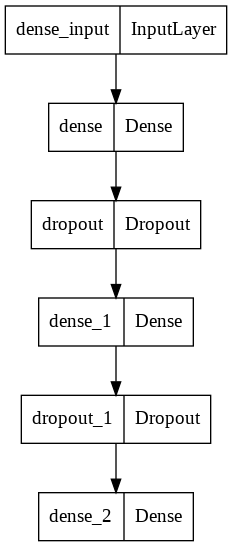

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model,to_file='model.png')

# You'll see  a bunch of new files in the contents dir. 

# Next we need to create the  template and static directory that the flask app needs/wants.

In [ ]:
!mkdir templates
!mkdir static

mkdir: cannot create directory ‘templates’: File exists
mkdir: cannot create directory ‘static’: File exists


In [ ]:
#!wget -P /content/templates https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/chat.html
!wget -P '/content/drive/MyDrive/Colab Notebooks/Chatbot/templates' https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/chat.html

--2022-11-28 04:10:12--  https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/chat.html
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3467 (3.4K) [text/plain]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/Chatbot/templates/chat.html.10’

chat.html.10        100%[===================>]   3.39K  --.-KB/s    in 0.001s  

2022-11-28 04:10:12 (3.16 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/Chatbot/templates/chat.html.10’ saved [3467/3467]



In [ ]:
#!wget -P /content/static https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/static/style.css
!wget -P '/content/drive/MyDrive/Colab Notebooks/Chatbot/static' https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/static/style.css

--2022-11-28 04:10:12--  https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/static/style.css
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12518 (12K) [text/plain]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/Chatbot/static/style.css.9’

style.css.9         100%[===================>]  12.22K  --.-KB/s    in 0.003s  

2022-11-28 04:10:12 (4.56 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/Chatbot/static/style.css.9’ saved [12518/12518]



we need to get the home.html file

In [ ]:
#!wget -P /content/templates https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/home.html
!wget -P '/content/drive/MyDrive/Colab Notebooks/Chatbot/templates' https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/home.html

--2022-11-28 04:10:12--  https://raw.githubusercontent.com/jumli-gazali/ppl-chatbot/main/home.html
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625 (1.6K) [text/plain]
Saving to: ‘/content/drive/MyDrive/Colab Notebooks/Chatbot/templates/home.html.10’

home.html.10        100%[===================>]   1.59K  --.-KB/s    in 0.001s  

2022-11-28 04:10:12 (1.80 MB/s) - ‘/content/drive/MyDrive/Colab Notebooks/Chatbot/templates/home.html.10’ saved [1625/1625]



In [ ]:
!touch 'drive/MyDrive/Colab Notebooks/Chatbot/storage.txt'

touch: cannot touch 'drive/MyDrive/Colab Notebooks/Chatbot/storage.txt': No such file or directory


next we'll run the chat UI

In [ ]:
from flask import Flask, render_template, request

from flask_ngrok import run_with_ngrok


import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import pickle
import numpy as np

from keras.models import load_model
model = load_model('/content/drive/MyDrive/Colab Notebooks/Chatbot/model h5/chatbot_model.h5')
import json
import random
import time

## end keras chat brain

## vars
now = time.time()# float

filename = str(now)+"_chatlog.txt" #create chatlog

intents = json.loads(open('intents.json').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))
    
## end vars

class Storage:
    old_answers=[] #storage for answers
    
    @classmethod
    def save_storage(cls):
        with open ("storage.txt", "w") as myfile:
            for answer in Storage.old_answers:
                
                myfile.write(answer+"\n")

    @classmethod
    def load_storage(cls):
        Storage.old_answers=[]
        with open ('storage.txt', 'r') as myfile:
            lines = myfile.readlines()
            for line in lines:
                Storage.old_answers.append(line.strip())
        print (Storage.old_answers)


app = Flask(__name__)
run_with_ngrok(app) 

def bot_response(userText):

    '''fake brain'''
    print ("your q was: " + userText)
    return "your q was: " + userText
   
## new funcs
def clean_up_sentence(sentence):
    """tokenizes the sentences"""
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence

def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def getResponse(ints, intents_json):
    '''read in the intents file'''
    #pseudo code
    #assume old answers are inside
    # old_answers = ['response1','response2']

    #load old answers into storage
    Storage.load_storage()
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    old_answers = Storage.old_answers  # [:-len(list_of_intents)]
    possible_responses = [i['responses'] for i in list_of_intents if i['tag']== tag ][0]
    history = Storage.old_answers[-len('possible_responses'):]
    print("** possible answers and history old answers",possible_responses,history)
    unused_answers = [answer for answer in possible_responses if answer not in history ] # list comprehension
    print(unused_answers, " unused answers")
    unused_two = history[-(len(possible_responses)-1):]
    print(unused_two,'last five answers')
    try:
        result = random.choice([answer for answer in possible_responses if answer not in unused_two ])
    except IndexError:
        print("I'm out of options, I will choose random.")
        result = random.choice(possible_responses)

    Storage.old_answers.append(result) 
    Storage.old_answers= Storage.old_answers[-20:] 
    Storage.save_storage()

  
    return result,tag

def chatbot_response(msg):
    '''this func is important'''
    ints = predict_class(msg, model)
    res,tag = getResponse(ints, intents)
    return res,tag


def send():
    msg = EntryBox.get("1.0",'end-1c').strip()
    EntryBox.delete("0.0",END)

    if msg != '':
        ChatLog.config(state=NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground="#442265", font=("Verdana", 12 ))

        res = chatbot_response(msg)
        ChatLog.insert(END, "Bot: " + res + '\n\n')

        ChatLog.config(state=DISABLED)
        ChatLog.yview(END)
        #append to log file
        with open(filename,'a') as myfile:
            myfile.write("user: "+ msg + "\n")
            myfile.write("bot: "+ res + "\n")

## end new funcs

@app.route('/')
def home():
    return render_template('home.html')

#
@app.route('/chat')
def chat():
    return render_template('chat.html')

@app.route("/get")
def get_bot_response():    
    print ("get is called")
    userText = request.args.get('msg')    
    # return str(bot.get_response(userText)) 
    # return bot_response(userText)
    res,tag = chatbot_response(userText)
    with open( "/content/drive/MyDrive/Colab Notebooks/Chatbot/logfile.csv", "a" ) as logfile:
        logfile.write(str(now)+","+userText+","+res+","+tag+","+"\n")
        

    return res + '<p style="font-size:8pt;">tag: ' + tag + '</p>'
    



if __name__ == '__main__':
  app.run()
#    app.run(debug=True)

INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://198b-35-245-11-26.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:11:57] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:11:58] "GET /Logo/logo.jpeg HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:11:58] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:12:04] "GET /chat HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:12:04] "GET /static/styles/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:12:05] "GET /Logo/logo.jpeg HTTP/1.1" 404 -


get is called
1/1 [==============================] - 0s 105ms/step
['Gedung IGD terletak di sebelah barat Gedung A selurusan dengan gerbang masuk RSMY terdiri dari 3 lantai', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1']
** possible answers and history old answers ['Di Gedung A, Lantai 1', 'Lantai 1 Gedung A'] ['Lantai 1 Gedung A', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan b

INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:12:19] "GET /get?msg=daftar HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:12:22] "GET /chat HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:12:23] "GET /static/style.css HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:12:23] "GET /Logo/logo.jpeg HTTP/1.1" 404 -


get is called
1/1 [==============================] - 0s 21ms/step


INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:12:43] "GET /get?msg=dimana%20administrasi%20pendaftaran HTTP/1.1" 200 -


['Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A']
** possible answers and history old answers ['Di Gedung A, Lantai 1', 'Lantai 1 Gedung A'] ['Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di

[2022-11-28 04:12:52,875] ERROR in app: Exception on /get [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 33, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1612, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1598, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-14-9756fb4f4f5d>", line 170, in get_bot_response
    res,tag = chatbot_response(userText

['Lantai 1 Gedung A', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A, Lantai 1']


INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:13:16] "GET /chat HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:13:16] "GET /Logo/logo.jpeg HTTP/1.1" 404 -


get is called
1/1 [==============================] - 0s 17ms/step


[2022-11-28 04:13:27,963] ERROR in app: Exception on /get [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1982, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1614, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1517, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 33, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1612, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1598, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-14-9756fb4f4f5d>", line 170, in get_bot_response
    res,tag = chatbot_response(userText

['Lantai 1 Gedung A', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A, Lantai 1']
get is called
1/1 [==============================] - 0s 21ms/step


INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:13:41] "GET /get?msg=persalinan HTTP/1.1" 200 -


['Lantai 1 Gedung A', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A, Lantai 1']
** possible answers and history old answers ['Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar'] ['Lantai 1 Gedung A', 'Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', '

INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:14:13] "GET /get?msg=dimana%20gedung%20a HTTP/1.1" 200 -


['Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A, Lantai 1', 'Mohon masukkan pesan dengan benar']
** possible answers and history old answers ['Di Gedung A Lantai 2', 'Lantai 2 Gedung A'] ['Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pes

INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:14:29] "GET /get?msg=dimana%20ruang%20mawar HTTP/1.1" 200 -


['Lantai 1 Gedung A', 'Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A, Lantai 1', 'Mohon masukkan pesan dengan benar', 'Di Gedung A Lantai 2']
** possible answers and history old answers [' Di Gedung C Lantai 1', 'Lantai 1 Gedung C'] ['Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Ge

INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:17:41] "GET /get?msg=dimana%20gedung%20b HTTP/1.1" 200 -


['Di Gedung A Lantai 2', 'Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A, Lantai 1', 'Mohon masukkan pesan dengan benar', 'Di Gedung A Lantai 2', 'Di Gedung C Lantai 1']
** possible answers and history old answers ['Di Gedung A Lantai 2', 'Lantai 2 Gedung A'] ['Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1', 'Lantai 1 G

INFO:werkzeug:127.0.0.1 - - [28/Nov/2022 04:17:53] "GET /get?msg=halo HTTP/1.1" 200 -


['Di Gedung Fatmawati Lantai 1', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1', 'Lantai 1 Gedung A', 'Di Gedung A, Lantai 1', 'Mohon masukkan pesan dengan benar', 'Di Gedung A Lantai 2', 'Di Gedung C Lantai 1', 'Di Gedung A Lantai 2']
** possible answers and history old answers ['Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar'] ['mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung C', 'Mohon masukkan pesan dengan benar', 'mohom Ketikan pesan dengan benar', 'Lantai 1 Gedung A', 'Di Gedung A Lantai 1', 'Di Gedung A, Lantai 1', 'Di Lantai 2', 'Mohon masukkan pesan dengan benar', 'Di Gedung A, Lantai 1', 'Lan